In [1]:
import pandas as pd

df_train = pd.read_csv('/home/ankur/Desktop/ML_DL_Projects/data/cmi-detect-behavior-with-sensor-data/train.csv')
df_test = pd.read_csv('/home/ankur/Desktop/ML_DL_Projects/data/cmi-detect-behavior-with-sensor-data/test.csv')

In [2]:
df_train = df_train.interpolate(method="linear", axis=0)
nan_columns_X = df_train.columns[df_train.isnull().any()].tolist()
print("Columns in X with NaNs:\n", nan_columns_X)

/tmp/ipykernel_99420/2495073133.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_train = df_train.interpolate(method="linear", axis=0)


Columns in X with NaNs:
 []


In [3]:
df_train.drop([
 'row_id',
 'sequence_type',
 'subject',
 'orientation',
 'behavior',
 'phase'], axis=1, inplace=True)

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Example: df has a column "label" with 18 string classes
encoder = LabelEncoder()
df_train["gesture_encoded"] = encoder.fit_transform(df_train["gesture"])

# Check mapping
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Class Mapping:", class_mapping)

Class Mapping: {'Above ear - pull hair': 0, 'Cheek - pinch skin': 1, 'Drink from bottle/cup': 2, 'Eyebrow - pull hair': 3, 'Eyelash - pull hair': 4, 'Feel around in tray and pull out an object': 5, 'Forehead - pull hairline': 6, 'Forehead - scratch': 7, 'Glasses on/off': 8, 'Neck - pinch skin': 9, 'Neck - scratch': 10, 'Pinch knee/leg skin': 11, 'Pull air toward your face': 12, 'Scratch knee/leg skin': 13, 'Text on phone': 14, 'Wave hello': 15, 'Write name in air': 16, 'Write name on leg': 17}


In [5]:
df_train.drop([
 'gesture'], axis=1, inplace=True)

In [6]:
df_imu_columns= [
 'sequence_id',
 'sequence_counter',
 'acc_x',
 'acc_y',
 'acc_z',
 'rot_w',
 'rot_x',
 'rot_y',
 'rot_z',]

df_imu_labels = df_train[['sequence_id','gesture_encoded']]
df_imu = df_train[df_imu_columns]
df_imu.columns

Index(['sequence_id', 'sequence_counter', 'acc_x', 'acc_y', 'acc_z', 'rot_w',
       'rot_x', 'rot_y', 'rot_z'],
      dtype='object')

In [7]:
del df_train
import gc 
gc.collect()

0

In [8]:
df_imu_labels.shape,df_imu.shape

((574945, 2), (574945, 9))

In [9]:
import numpy as np
import pandas as pd

def prepare_whole_sequences(df_x, df_y, max_steps=400):

    df_x = df_x.sort_values(by=["sequence_id", "sequence_counter"], 
                    ascending=[True, True]).reset_index(drop=True)

    # Drop unnecessary columns early
    df_x = df_x.drop(columns=["sequence_counter"])  
    
    # Get number of features (exclude seq_id)
    feature_cols = [c for c in df_x.columns if c != "sequence_id"]
    n_features = len(feature_cols)
    
    # Find number of unique sequences
    sequence_ids = df_x["sequence_id"].unique()
    n_sequences = len(sequence_ids)

    # Preallocate final arrays
    X = np.zeros((n_sequences, max_steps, n_features), dtype=np.float32)
    Y = np.zeros((n_sequences,), dtype=np.float32)  
    for i, seq_id in enumerate(sequence_ids):
        if i % 100 == 0:
            print(f"Processing {i}/{n_sequences}")

        # Extract sensor data for this sequence
        seq = df_x[df_x["sequence_id"] == seq_id][feature_cols].values.astype(np.float32)
        seq_len = len(seq)

        # Case 1: Longer than max_steps → take last `max_steps`
        if seq_len > max_steps:
            seq = seq[-max_steps:]

        # Case 2: Shorter than max_steps → pad at the end (already handled by preallocation with zeros)
        X[i, :seq_len, :] = seq

        # Extract label row (drop sequence_id col, keep only class columns)
        label_row = df_y[df_y["sequence_id"] == seq_id].drop(columns=["sequence_id"]).iloc[0].values
        Y[i] = label_row.item() 
    
    return X, Y


In [ ]:
x_imu_train,y_imu_train = prepare_whole_sequences(df_imu,df_imu_labels)
x_imu_train.shape,y_imu_train.shape

Processing 0/8151
Processing 100/8151
Processing 200/8151
Processing 300/8151
Processing 400/8151
Processing 500/8151
Processing 600/8151
Processing 700/8151
Processing 800/8151
Processing 900/8151
Processing 1000/8151
Processing 1100/8151
Processing 1200/8151
Processing 1300/8151
Processing 1400/8151
Processing 1500/8151
Processing 1600/8151
Processing 1700/8151
Processing 1800/8151
Processing 1900/8151
Processing 2000/8151
Processing 2100/8151
Processing 2200/8151
Processing 2300/8151
Processing 2400/8151
Processing 2500/8151
Processing 2600/8151
Processing 2700/8151
Processing 2800/8151
Processing 2900/8151
Processing 3000/8151
Processing 3100/8151
Processing 3200/8151
Processing 3300/8151
Processing 3400/8151
Processing 3500/8151
Processing 3600/8151
Processing 3700/8151
Processing 3800/8151
Processing 3900/8151
Processing 4000/8151
Processing 4100/8151
Processing 4200/8151
Processing 4300/8151
Processing 4400/8151
Processing 4500/8151
Processing 4600/8151
Processing 4700/8151
Proc

((8151, 400, 7), (8151,))

In [11]:
x_imu_train[1,1, :]

array([ 2.6132812 , -0.22265625,  9.691406  ,  0.32086182, -0.12982178,
       -0.03161621, -0.9376221 ], dtype=float32)

In [12]:
del df_imu_labels
del df_imu
import gc 
gc.collect()

0

In [13]:
from sklearn.model_selection import train_test_split

# stratified split train+temp vs test
X_train_imu_sensor, X_val_imu_senosr, y_train_imu_sensor, y_val_imu_sensor = train_test_split(
    x_imu_train, y_imu_train, test_size=0.1, stratify=y_imu_train, random_state=42
)

In [14]:
X_train_imu_sensor.shape, X_val_imu_senosr.shape, y_train_imu_sensor.shape, y_val_imu_sensor.shape

((7335, 400, 7), (816, 400, 7), (7335,), (816,))

In [15]:
del x_imu_train
del y_imu_train
import gc 
gc.collect()

0

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D, Attention, LayerNormalization,
    Masking, Concatenate, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Masking, GRU
from tensorflow.keras import backend as K
import tensorflow as tf


2025-08-29 10:50:46.536761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 10:50:46.546335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756444846.554013   99420 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756444846.556195   99420 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756444846.562425   99420 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [17]:
print(X_train_imu_sensor.shape,y_train_imu_sensor.shape)

(7335, 400, 7) (7335,)


In [18]:
# model = Sequential([
#     Input(shape=(400, 7)),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     Conv1D(filters=128, kernel_size=5, activation='relu'),
#     GRU(64, return_sequences=False), 
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(18, activation='softmax')  # for 18-class classification
# ])


# # Compile model with precision, recall, f1
# model.compile(
#     optimizer='adam',
#     loss=SparseCategoricalCrossentropy(),
#     metrics=[
#         'accuracy'
#     ]
# )

# model.summary()

# history = model.fit(
#     X_train_imu_sensor, 
#     y_train_imu_sensor,
#     epochs=20,
#     batch_size=32,
#     validation_split=0.1,   # 10% of training data will be used for validation
#     verbose=1
# )
# history

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D, Attention, LayerNormalization,
    Masking, Concatenate, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy



def create_single_task_model(
    max_len=400,
    n_features=7,
    n_classes=18
):
    """
    Single-task version of the model
    """
    input_layer = Input(shape=(max_len, n_features))
    x = Masking(mask_value=0.0)(input_layer)
    
    # Conv1D blocks
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # LSTM layers
    x = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
    x = LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
    
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = tf.keras.layers.Add()([x, attention_output])
    x = LayerNormalization()(x)
    
    # Global pooling and dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer

    output = Dense(18, activation='softmax', name='gesture_output')(x)
    model = Model(inputs=input_layer, outputs=output)
  # # Compile model
    model.compile(
     optimizer='adam',
     loss=SparseCategoricalCrossentropy(),   
     metrics=[
        'accuracy']
    )

    model.summary()
    
    return model

In [21]:
print(X_train_imu_sensor.shape, y_train_imu_sensor.shape)
print(np.unique(y_train_imu_sensor))

(7335, 400, 7) (7335,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]


In [22]:
Conv1d_lstm_attention_model = create_single_task_model()
Conv1d_lstm_attention_model.summary()

2025-08-29 10:51:34.975128: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-08-29 10:51:34.975155: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-29 10:51:34.975158: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: ankur-Legion-5-15IRX9
2025-08-29 10:51:34.975160: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: ankur-Legion-5-15IRX9
2025-08-29 10:51:34.975315: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 575.64.3
2025-08-29 10:51:34.975330: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 400, 7)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 400, 64)   │      1,408 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 400, 128)  │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 400, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 400, 64)   │     24,640 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 400, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 400, 128)  │     98,816 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 400, 64)   │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 64)   │    132,672 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 400, 64)   │          0 │ lstm_1[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 400, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]   

 Total params: 350,546 (1.34 MB)

 Trainable params: 350,034 (1.34 MB)

 Non-trainable params: 512 (2.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 400, 7)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 400, 64)   │      1,408 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 400, 128)  │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 400, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 400, 64)   │     24,640 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 400, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 400, 128)  │     98,816 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 400, 64)   │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 64)   │    132,672 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 400, 64)   │          0 │ lstm_1[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 400, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]   

 Total params: 350,546 (1.34 MB)

 Trainable params: 350,034 (1.34 MB)

 Non-trainable params: 512 (2.00 KB)

In [23]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',   # or 'val_accuracy'
    patience=5,           # stop if no improvement for 5 epochs
    restore_best_weights=True  # roll back to the best epoch
)

history = Conv1d_lstm_attention_model.fit(
    X_train_imu_sensor, 
    y_train_imu_sensor,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    validation_data=(X_val_imu_senosr, y_val_imu_sensor),
    verbose=1
)
history

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 100s 406ms/step - accuracy: 0.0988 - loss: 2.7703 - val_accuracy: 0.1348 - val_loss: 2.6277
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 96s 418ms/step - accuracy: 0.1253 - loss: 2.6011 - val_accuracy: 0.1679 - val_loss: 2.4537
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 96s 417ms/step - accuracy: 0.1663 - loss: 2.4336 - val_accuracy: 0.0980 - val_loss: 2.7544
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 96s 415ms/step - accuracy: 0.2059 - loss: 2.2432 - val_accuracy: 0.2267 - val_loss: 2.1069
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 426ms/step - accuracy: 0.2331 - loss: 2.1307 - val_accuracy: 0.2377 - val_loss: 2.0978
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 102s 443ms/step - accuracy: 0.2588 - loss: 2.0451 - val_accuracy: 0.2721 - val_loss: 1.9995
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 425ms/step - accuracy: 0.2721 - loss: 1.9823 - val_accuracy: 0.2782 - val_loss: 1.8963
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 424ms/step - accuracy: 0.2783 - loss:

In [24]:
history_2 = Conv1d_lstm_attention_model.fit(
    X_train_imu_sensor, 
    y_train_imu_sensor,
    epochs=60,   # continue until total = 60 (so 10 more if last was 50)
    batch_size=32,
    callbacks=[early_stop],
    validation_data=(X_val_imu_senosr, y_val_imu_sensor),
    verbose=1,
    initial_epoch=history.epoch[-1] + 1  # continue from last epoch
)


Epoch 41/60
230/230 ━━━━━━━━━━━━━━━━━━━━ 94s 410ms/step - accuracy: 0.4473 - loss: 1.4472 - val_accuracy: 0.4583 - val_loss: 1.4250
Epoch 42/60
230/230 ━━━━━━━━━━━━━━━━━━━━ 97s 421ms/step - accuracy: 0.4479 - loss: 1.4350 - val_accuracy: 0.4436 - val_loss: 1.4363
Epoch 43/60
230/230 ━━━━━━━━━━━━━━━━━━━━ 97s 422ms/step - accuracy: 0.4558 - loss: 1.4217 - val_accuracy: 0.4363 - val_loss: 1.4435
Epoch 44/60
230/230 ━━━━━━━━━━━━━━━━━━━━ 97s 422ms/step - accuracy: 0.4483 - loss: 1.4304 - val_accuracy: 0.4363 - val_loss: 1.4386
Epoch 45/60
230/230 ━━━━━━━━━━━━━━━━━━━━ 97s 423ms/step - accuracy: 0.4539 - loss: 1.4319 - val_accuracy: 0.4534 - val_loss: 1.4261


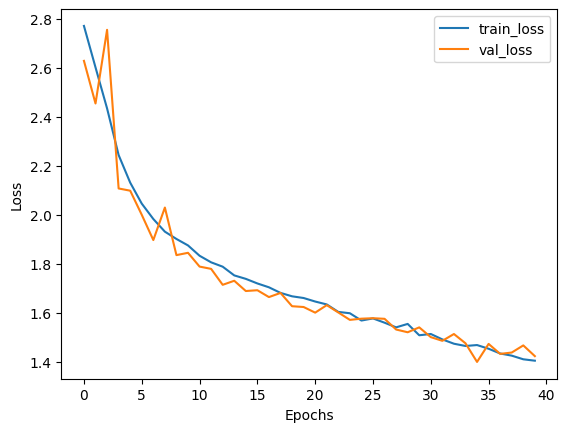

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
Conv1d_lstm_attention_model.evaluate(X_val_imu_senosr, y_val_imu_sensor)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4583 - loss: 1.4250


[1.4250123500823975, 0.4583333432674408]

In [29]:
Conv1d_lstm_attention_model.save("cmi_imu_18.h5")

In [32]:
from tensorflow.keras.models import load_model
best_model = load_model("cmi_imu_18.h5")

In [35]:
best_model.evaluate(X_val_imu_senosr, y_val_imu_sensor)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4583 - loss: 1.4250


[1.4250123500823975, 0.4583333432674408]

In [43]:
best_model.evaluate(X_val_imu_senosr, y_val_imu_sensor)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4583 - loss: 1.4250


[1.4250123500823975, 0.4583333432674408]

In [44]:
x_test = X_val_imu_senosr[0]

In [49]:
x_test.shape

(400, 7)

In [50]:
x_test = x_test.reshape(1,400,7)

In [51]:
x_test.shape

(1, 400, 7)

In [52]:
best_model.predict(x_test)

/home/ankur/Desktop/ML_DL_Projects/ml_projects_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


array([[9.00319442e-02, 1.88373491e-01, 2.96343533e-05, 1.49081126e-01,
        1.94808528e-01, 7.23301491e-04, 1.11307979e-01, 4.10223529e-02,
        2.08055688e-04, 1.12157352e-01, 1.09719075e-01, 4.88354963e-05,
        1.86358040e-04, 6.05072564e-05, 6.86917512e-04, 5.68825672e-05,
        1.45634310e-03, 4.12392656e-05]], dtype=float32)

In [54]:
import numpy as np

# Get probabilities
y_pred_probs = Conv1d_lstm_attention_model.predict(x_test)

# Get the predicted integer class
y_pred_int = np.argmax(y_pred_probs, axis=1)

# Convert back to original string labels
y_pred_labels = encoder.inverse_transform(y_pred_int)

print("Predicted integers:", y_pred_int)
print("Predicted labels:", y_pred_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted integers: [4]
Predicted labels: ['Eyelash - pull hair']


In [55]:
import joblib
joblib.dump(encoder, "cmi_imu18_class_encoder.pkl")

['cmi_imu18_class_encoder.pkl']

In [56]:
encoder = joblib.load("cmi_imu18_class_encoder.pkl")

In [58]:
preditoin_test = best_model.predict(x_test)
y_pred_int = np.argmax(preditoin_test, axis=1)

# Convert back to original string labels
y_pred_labels = encoder.inverse_transform(y_pred_int)

print("Predicted integers:", y_pred_int)
print("Predicted labels:", y_pred_labels [0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted integers: [4]
Predicted labels: Eyelash - pull hair


In [59]:
import numpy as np

# After fitting encoder
classes = encoder.classes_
np.save("imu_18_classes.npy", classes) 
print(classes)

['Above ear - pull hair' 'Cheek - pinch skin' 'Drink from bottle/cup'
 'Eyebrow - pull hair' 'Eyelash - pull hair'
 'Feel around in tray and pull out an object' 'Forehead - pull hairline'
 'Forehead - scratch' 'Glasses on/off' 'Neck - pinch skin'
 'Neck - scratch' 'Pinch knee/leg skin' 'Pull air toward your face'
 'Scratch knee/leg skin' 'Text on phone' 'Wave hello' 'Write name in air'
 'Write name on leg']
